## Supervised learning assignemtn
##### Name: Daan Steur
##### Studentnumber: 379943
##### Supervisor: Drs. Fenna Feenstra
##### Course: DSLS Data Science 3: Unsupervised learning
##### Date: 27th of may

## Prediction of health parameters based on patient informatio. 

### Assignment 
Choose one of the assignments (beginners, intermediate, advanced). Note that each of the assignments can lead to a sufficient mark, you should just choose the one you like the most. If you do not like one of the assignments, you can use your own dataset as well. Just make sure that you explain your choices! 

### Data source
Read the two datasets in and conduct proper preprocessing. Combine the clinical data with the genetic data. Use unsupervised learning to develop an accurate machine learning model that can predict lung cancer. Explain your choices. Make sure you properly inspect and preprocess the data. (Check for missing data, skewness, distribution, sample, linearity, correlations etc.). Use an argumentative approach. 
clinical meta data: https://wiki.cancerimagingarchive.net/download/attachments/16056856/Lung3.metadata.xls?version=1&modificationDate=1404237338168&api=v2

Gene Expression data: https://ftp.ncbi.nlm.nih.gov/geo/series/GSE58nnn/GSE58661/matrix/


Loading data and packages

In [15]:
# load packages
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



In [16]:
# simpel function to plot clusters
def plot_clus():
    plt.scatter(datatrans[:,0],datatrans[:,1],c=pred_kmeans)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'PCA predicted scores with {n_clusters} clusters')
    plt.show()

In [17]:
# load data
url = "https://wiki.cancerimagingarchive.net/download/attachments/16056856/Lung3.metadata.xls?version=1&modificationDate=1404237338168&api=v2"
meta = pd.read_excel(url)

# select cancer celtypes andtumor size 'characteristics.tag.histology','characteristics.tag.tumor.size.maximumdiameter'
meta = meta[['characteristics.tag.histology','characteristics.tag.tumor.size.maximumdiameter']]
# meta.head()

# read in genetic data
data = pd.read_table('data/GSE58661_series_matrix.txt.gz', sep='\t', header=61, index_col=0,quotechar='"', compression='gzip')
# remove last column with end of table text
data.drop(index=data.index[-1], 
        axis=0, 
        inplace=True)
# data.head()

Merging lung data and meta data

In [18]:
# indicating that both lung data and the meta data have 89 variables in on form of the dataframe,
# the lung data will be transposed to be able to fit the meta data
# merge lung data and meta data
data_transposed = data.T
data_transposed.reset_index(inplace=True)
# merge on index
merge = pd.concat([data_transposed, meta], axis=1)
# renamw characteristics.tag.histology and characteristics.tag.tumor.size.maximumdiameter to histology and tumor_size
merge.rename(columns={'characteristics.tag.histology':'histology',
                      'characteristics.tag.tumor.size.maximumdiameter':'tumor_size'}, inplace=True)

# set first column as index
# merge.set_index(merge.columns[0], inplace=True)
# drop na values in meta data
merge.dropna(inplace=True)
# drop index column
merge.drop(merge.columns[0], axis=1, inplace=True)
# set histology as index
merge.set_index('histology', inplace=True)
merge.reset_index(inplace=True)
merge.head()

,histology,AFFX-BioB-3_at,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioC-3_at,AFFX-BioC-5_at,AFFX-BioDn-3_at,AFFX-BioDn-5_at,AFFX-BkGr-GC03_at,AFFX-BkGr-GC04_at,...,merck2-Z43503_at,merck2-Z47244_x_at,merck2-Z47250_x_at,merck2-Z48501_s_at,merck2-Z48633_s_at,merck2-Z70222_a_at,merck2-Z70608_x_at,merck2-Z72499_a_at,merck2-Z75331_a_at,tumor_size
0,"Squamous Cell Carcinoma, NOS",7.376915,6.984530,7.330576,10.922741,11.032030,13.411168,12.625445,1.464847,1.416673,...,4.350631,7.506299,9.774634,11.295187,10.286077,6.892053,1.777216,9.031084,7.284069,4.0
1,"Adenocarcinoma, Papillary, NOS",8.024915,7.427048,8.010530,11.390638,11.533338,13.546671,12.898906,1.502126,1.398866,...,3.578359,5.516440,4.601167,11.443442,11.173715,5.513603,1.940099,9.527973,6.985508,1.3
2,Non-Small Cell,7.522543,7.077207,7.334551,10.936703,11.018510,13.360017,12.540647,1.355337,1.343599,...,2.937384,6.310065,6.315107,11.584115,10.586540,6.112918,1.753519,9.515653,6.556233,11.0
3,"Squamous Cell Carcinoma, NOS",7.211031,6.753131,7.077163,10.701328,10.823792,13.340075,12.420624,1.296788,1.244117,...,3.119091,7.257312,8.118139,10.998377,10.634072,7.041829,1.686633,9.464486,6.244336,7.8
4,"Adenocarcinoma, NOS",7.704962,7.195947,7.753484,11.221732,11.276973,13.403260,12.619452,1.400080,1.380652,...,3.597535,8.883804,10.628500,11.102958,10.741879,7.560786,1.988420,9.558521,5.562862,3.5


Data exploration

Series([], dtype: int64)
Series([], dtype: float64)


Squamous Cell Carcinoma, NOS                                    33
Adenocarcinoma, NOS                                             25
Non-Small Cell                                                   7
Adenocarcinoma, Papillary, NOS                                   4
Adenocarcinoma, Bronchiolo-alveolar Features                     4
Adenocarcinoma, Acinar Type                                      3
Solid Type And Acinar                                            2
Adenocarcinoma With Papillary Features                           2
Adenocarcinoma, Mixed                                            1
Adenocarcinoma, Mucinous With Bronchiolo-alveolar Features       1
Squamous Cell Carcinoma, Other (Specify) with adeno features     1
Adenocarcinoma With Mucinous Features                            1
Carcinoma, Large Cell, Neuroendocrine                            1
Squamous Cell Carcinoma, Other (Specify)endobronchial            1
Squamous Cell Carcinoma, Papillary                            

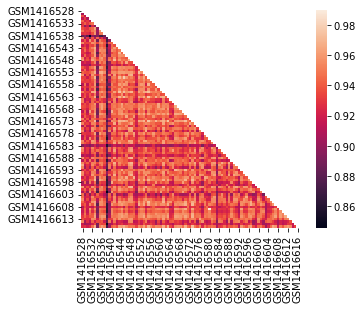

In [19]:
# check for missinbg data
missing = data.isnull().sum()
missing =  missing[missing > 0]
print(missing)

# check for skenewss of data
skew = data.skew()
skew = skew[skew > 3]
print(skew)

# Calculate correlation between each pair of variable
corr_matrix=data.corr()
 
# Can be great to plot only a half matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, square=True)


# intrust lies within the classification of the different cancer ecotypes
# count characteristics.tag.histology
merge['histology'].value_counts()

There are no missing values, the skewness is within borders, there are a total of 17 cancer cell-types, so in an ideal situation 17 cluster should be able to be classified. in reality this number will most likely be a lot lower, due to similarity cell-types and the low number of samples for the majority of the cell types. 
Heatmap shows the majority of the data to have high correlation. 

In [20]:
# set data and cell classes 
data = merge
sample = data.pop('histology')
pca=PCA()
#Fit PCA to the dataset (only variables, excluding class)
pca.fit(data)
#Calculating rotated PCA scores
datatrans=pca.transform(data)
classes=sample

#scaling the data for better visualization
data_s = preprocessing.scale(data)
data_s = pd.DataFrame(data)

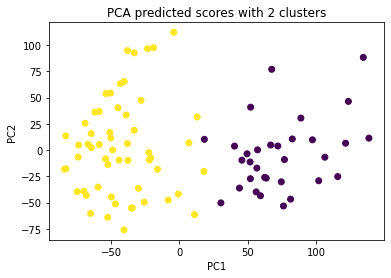

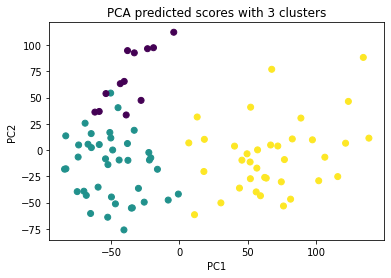

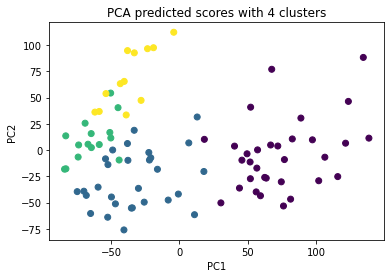

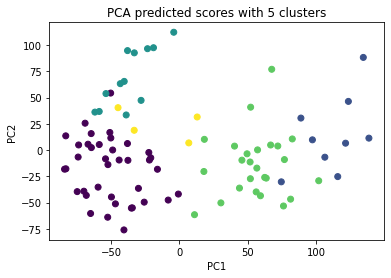

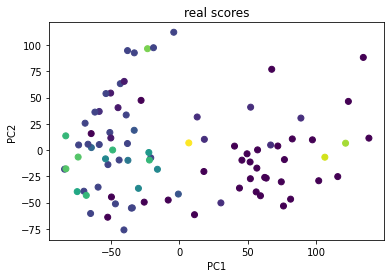

In [21]:
# Plotting scores in terms of K-means. As a matter of fact.
# If n_clusters increases, we start can start observing overlapping of the clusters
n_clusters = range(2,6) 

# fig, ax = plt.subplots(4, 4, figsize=(8,6))   
for n_clusters in n_clusters:
    kmeans = cluster.KMeans(n_clusters = n_clusters , init = 'k-means++', random_state = 42)
    pred_kmeans = kmeans.fit_predict(data_s)
    pred_kmeans = pred_kmeans+1
    plot_clus()


# Plotting scores but now color coded with real classes
plt.figure()
classes=pd.factorize(classes)
plt.scatter(datatrans[:,0],datatrans[:,1],c=classes[0])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('real scores')
plt.show()


As you can see there is not a great separation of cell types, in the most extreme situation still 4-5 clusters can be separated. 

but overall no distinct patterns of more than 3 clusters can be observed.

To possibly get a better separation of cell types, tSNE will be used.

In [22]:
# tsne is a dimensionality reduction technique that is used to visualize high dimensional data.
#but the accuracy of the clustering is not great above 50 dimensions
# reduce to 50 dimensions to better fit the tsne clustering
reduced_data = PCA(n_components=50,random_state=42).fit_transform(data_s)
reduced_data = pd.DataFrame(reduced_data)

# set data and cell classes
x = reduced_data.iloc
y = sample

tsne = TSNE(n_components=2, n_iter=10000, learning_rate='auto', perplexity=50).fit_transform(reduced_data)
tsne = pd.DataFrame(tsne)
tsne.columns = ['comp-1', 'comp-2']
# add sample 
tsne['sample'] = y

print(tsne)

sns.scatterplot(x='comp-1', y='comp-2', hue='sample', data=tsne)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


ValueError: 'n_components' should be inferior to 4 for the barnes_hut algorithm as it relies on quad-tree or oct-tree.

Conclusions

- 
- 
- 
- 
- 
- 